В этом уроке изучим вопросы мультиколлинеарности и отбора переменных в модели множественной линейной регрессии.

Ссылка на файл для экспериментов

https://docs.google.com/spreadsheets/d/1ilgN4nUDdtKdJRGGccQV_eXb3x9EMaAx/edit?usp=share_link&ouid=114299830697284631791&rtpof=true&sd=true

Все зависимости (если есть) в этом датасете только линейные, нелинейных зависимостей нет.

Здесь $u$ - зависимая переменная, которую требуется объяснить / предсказать. То есть требуется построить модель множественной линейной регрессии.

В качестве потенциальных предикторов рассматриваем $x, y, t$ и $z$.
Требуется найти и включить в модель значимые независимые предикторы. Слово "значимые" здесь означает, что влияние на $u$ статистически значимое (в качестве уровня значимости $\alpha$ положим 0.05). Слово "независимые" здесь означает, что предиктор независим от других предикторов ранее включенных в модель.

Эти потенциальные предиктороы могут не влиять на $u$ вовсе или быть сильно коррлелированы с другими предикторами (уже включенными в модель), а потому ничего существенно нового в модель не вносить.

* Вручную выберем предикторы, исходя из соображений здравого смысла.
* Используем методы пошагового отбора (Forward).
* Рассмотрим методы поиска предикторов из пакета sklearn.feature_selection.
* Используем методы регуляризации для борьбы с мультиколлинеарностью (Ridge и Lasso).


https://scikit-learn.org/stable/modules/feature_selection.html

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from google.colab import files

files.upload()
!ls
df = pd.read_excel('reg_experience.xlsx', index_col=0)#Data Frame
sampleSize = len(df)
df

Saving reg_experience.xlsx to reg_experience.xlsx
reg_experience.xlsx  sample_data


,x,y,t,z,u
0,132,188,105,15,1834
1,88,225,76,22,2045
2,89,183,119,15,1653
3,79,259,48,17,2270
4,117,160,138,13,1555
...,...,...,...,...,...
195,67,224,83,14,1967
196,112,144,160,26,1373
197,108,228,77,16,2083
198,116,199,99,24,1886


In [ ]:
df.describe()

,x,y,t,z,u
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,102.165000,199.895000,100.620000,19.625000,1854.495000
std,18.247262,31.149566,31.240606,5.016994,251.900575
min,51.000000,116.000000,13.000000,6.000000,1141.000000
25%,90.750000,179.750000,81.750000,16.000000,1681.250000
50%,102.500000,197.500000,102.000000,20.000000,1836.000000
75%,114.250000,220.250000,121.000000,23.000000,2018.500000
max,151.000000,291.000000,187.000000,37.000000,2612.000000


Для экспериментов нам потребуется еще один столбец $a$ в датасете, который преддставляет собой наблюдения за нормально распределенной случайной величиной. Очевидно, что этот столбец - просто шум; влиять на $u$ он не может. Сравнивая тесноту связи $u$ и $a$ с теснотой связи $u$ и других потеницальных предикторов, мы можем сказать, сильно ли лучше другие предикторы, чем просто шум.

In [ ]:
import numpy as np

np.random.seed(1)
tmp = 5 * np.random.randn(sampleSize) + 20
tmp = tmp.round(0)
df.insert(loc = 4, column = 'a', value = tmp)
df

,x,y,t,z,a,u
0,132,188,105,15,28.0,1834
1,88,225,76,22,17.0,2045
2,89,183,119,15,17.0,1653
3,79,259,48,17,15.0,2270
4,117,160,138,13,24.0,1555
...,...,...,...,...,...,...
195,67,224,83,14,12.0,1967
196,112,144,160,26,23.0,1373
197,108,228,77,16,22.0,2083
198,116,199,99,24,24.0,1886


# Чать 1

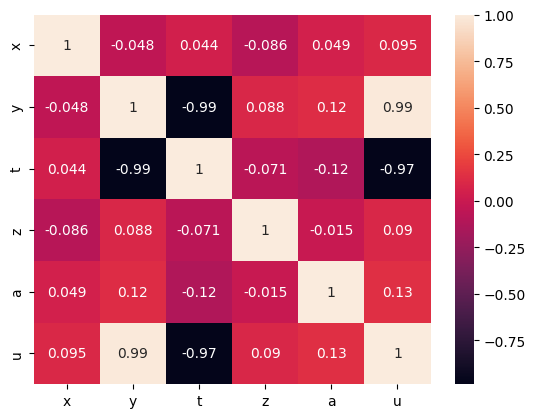

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
corr_matrix

,x,y,t,z,a,u
x,1.000000,-0.047693,0.044371,-0.086159,0.049135,0.095358
y,-0.047693,1.000000,-0.985824,0.088174,0.119923,0.985568
t,0.044371,-0.985824,1.000000,-0.070583,-0.120657,-0.971944
z,-0.086159,0.088174,-0.070583,1.000000,-0.014837,0.090361
a,0.049135,0.119923,-0.120657,-0.014837,1.000000,0.132513
u,0.095358,0.985568,-0.971944,0.090361,0.132513,1.000000


In [ ]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(df)

,x,y,t,z,a,u
x,0.0,0.5025,0.5327,0.2251,0.4896,0.1792
y,0.5025,0.0,0.0,0.2144,0.0908,0.0
t,0.5327,0.0,0.0,0.3206,0.0888,0.0
z,0.2251,0.2144,0.3206,0.0,0.8348,0.2032
a,0.4896,0.0908,0.0888,0.8348,0.0,0.0614
u,0.1792,0.0,0.0,0.2032,0.0614,0.0


**Обсуждение со студентами.**
Какой вывод можно сделать по результатам корреляционного анализиа? Влияет ли $x$ на $u$? Надо ли включать $x$ в модель?

Визуализируем связь $x$ и $u$. Подтверждает ли график сделанные выводы?

То же вопрос про влияние $t$ на $u$.

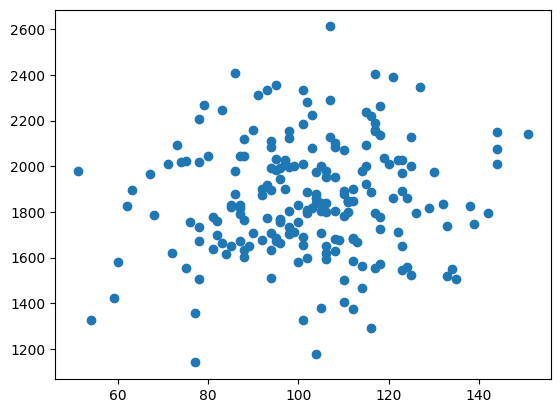

In [ ]:
plt.scatter(df['x'], df['u'])

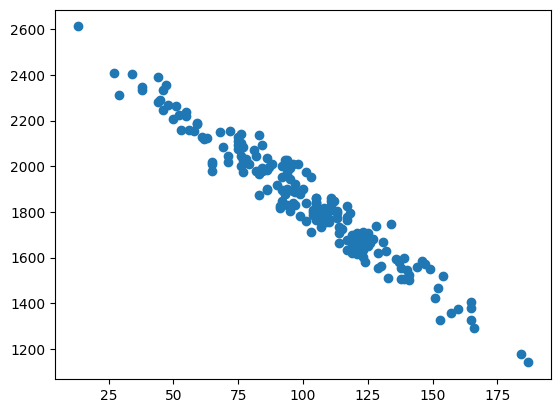

In [ ]:
plt.scatter(df['t'], df['u'])

Теперь узнаем, как данные были сгенерированы.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(1)
sampleSize = 200

x = 20 * np.random.randn(sampleSize) + 100
y = 30 * np.random.randn(sampleSize) + 200
t = 300 - y + 5 * np.random.randn(sampleSize)
z = 5 * np.random.randn(sampleSize) + 20

u = 2 * x + 8 * y + z + 25 * np.random.randn(sampleSize) + 30

#for y 30 * 8 = 240
#for x 20 * 2 = 40
#for z 5 * 1 = 5
#df = pd.DataFrame(list(zip(x, y, t, z, u)), columns =['x', 'y', 't', 'z', 'u'])
#df = df.round(0)

Формула
$$u = 2 * x + 8 * y + z + \varepsilon,$$
где $\varepsilon$ --- нормальная случайная величина с мат. ожиданием = 30 и стандартным отклонением = 25,
ясно показывает, что связь $u$ с $x$ быть должна.

Почему же в корреляционном анализе эта связь получается статистически незначимая? Тот же попрос про $u$ и $z$.



In [ ]:
residuals = u - 8 * y
pearsonr(residuals, x)

PearsonRResult(statistic=0.8415383039329434, pvalue=7.455822694369336e-55)

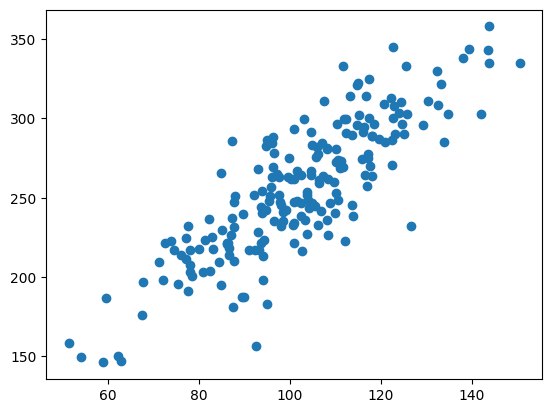

In [ ]:
plt.scatter(x, residuals)

Предиктор $x$ хорошо объясняет отстатки модели
$$u = Constanta + 8 * y.$$
Поэтому $x$ стоит включить в модель, сделав модель двухфакторной.

А предиктор $t$ что-то полезное внесет в модель $u = Constanta + 8* y$?

<Axes: xlabel='t', ylabel='u'>

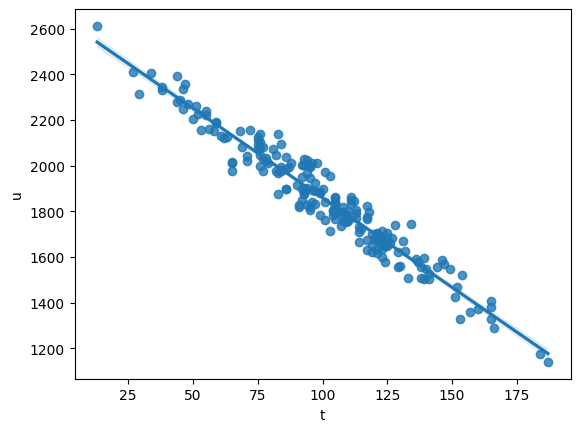

In [ ]:
sns.regplot(x="t", y="u", data=df)

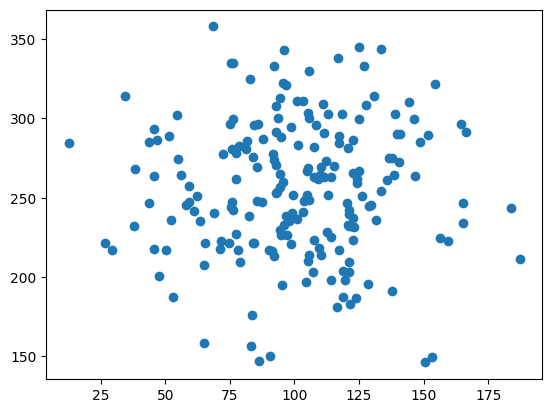

In [ ]:
plt.scatter(t, residuals)

Аналогично, по шагам включить в модель $x$ и $z.$

Можно ли было сразу понять, что $t$ не нужен в модели, зная о высокой корреляции $t$ и $y$?

Построим уравнение линейной регрессии, включив в модель все предикторы, в том числе заведомо ненужный "предиктор" $a$.

In [ ]:
df

,x,y,t,z,a,u
id,,,,,,
0,132,188,105,15,16.0,1834
1,88,225,76,22,23.0,2045
2,89,183,119,15,16.0,1653
3,79,259,48,17,22.0,2270
4,117,160,138,13,24.0,1555
...,...,...,...,...,...,...
195,67,224,83,14,20.0,1967
196,112,144,160,26,22.0,1373
197,108,228,77,16,24.0,2083


In [ ]:
factors = df.iloc[:,0:5]
response = df.iloc[:,5]

model = LinearRegression()
model.fit(factors, response)

r_sq = model.score(factors, response)
print('Coefficient of determination', r_sq * 100, '%')
print('intercept_', model.intercept_)
print('Coefficient of determination', model.coef_)

Coefficient of determination 99.18932285277948 %
intercept_ 50.43260997507946
Coefficient of determination [ 2.09452431  7.95379212 -0.06195689  0.77521285 -0.42945326]


Почему предиктор $t$, который в корреляционном (однофакторном) анализе был значимым в модель включен с таким ничтожно малым (-0.0336602) коэффициентом? Даже при $a$ коэффициент больше.

А корректно ли сравнивать кэффициенты при $t$ и $a$ в уравнении регресии с тем, чтобы делать какие-то выводы о силе влияния этих "предикторов" на $u$?

Let us imagine that t is weight in kg and its coefficient in the regression model is equal to 5.
Now let to measure t in gram instead. How the coefficient in regression model will change?

To make this comparison be correct you have to normalize all variables at the very beginning (before you build the linear regression model). To normalize = to divide by standard deviation.

# Часть 2

Будем использовать методы из sklearn.feature_selection.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

**1 вариант** Univariate feature selection

class sklearn.feature_selection.SelectKBest(score_func=\<function f_classif\>, *, k=10)

В качестве первого аргумента нужно передавать функцию (score_funccallable, default=f_classif)

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

* For regression: r_regression, f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif

по умолчанию f_classif, которая подходит для задач классификации.

Мы решаем задачу регрессии, а потому будем использовать первый рекомендуемый r_regression.

In [ ]:
from sklearn.feature_selection import SelectKBest, r_regression

selector = SelectKBest(r_regression, k=3)

selector.fit(factors, response)

SelectKBest(k=3, score_func=<function r_regression at 0x7ecdd4053880>)

Метод SelectKBest(r_regression, k=2) выбрал два предиктора $x$ и $y$. Соответствует ли этот результат ранее полученным?

А если найти три лучших предиктора?

In [ ]:
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[ 0.09535849  0.98556829 -0.97194418  0.09036089  0.10190989]
[ True  True False False  True]
['x' 'y' 'a']


Должны ли лучшие предикторы измениться, если предсказывать не $u$, а противоположный по знаку результат $-u$? Почему?

Проверим это.

In [ ]:
selector = SelectKBest(r_regression, k=2)

selector.fit(factors, -response)
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[-0.09535849 -0.98556829  0.97194418 -0.09036089  0.08580219]
[False False  True False  True]
['t' 'a']


Выбраны заведомо худшие результаты. Почему так произошло?

Означает ли это, что метод SelectKBest не должен применяться в задачах поиска предикторов в множественной регрессии?

На странице sklearn.feature_selection.SelectKBest
внимательно читаем See also и находим список функций, которые могут быть использованы в качестве score_func. *Да, тут небольшое противоречие в документации, увы*.

f_regression
F-value between label/feature for regression tasks.

Объяснить, почему r_regression не подходит здесь для задач отбора признака. А где и для чего r_regression может быть использован?

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=2)

selector.fit(factors, response)
#selector.fit(factors, -response)
print(selector.scores_)
print(selector.get_support())
print(selector.get_feature_names_out())

[1.81698404e+00 6.71175204e+03 3.38088336e+03 1.62999689e+00
 2.07793442e+00]
[False  True  True False False]
['y' 't']


Стал ли теперь результат инвариантен по отношению к знаку $u$? Можно ли теперь, когда используем правильную функцию для скоринга, применять метод SelectKBest для поиска предикторов, которые надо включить в модель множественной регрессии?

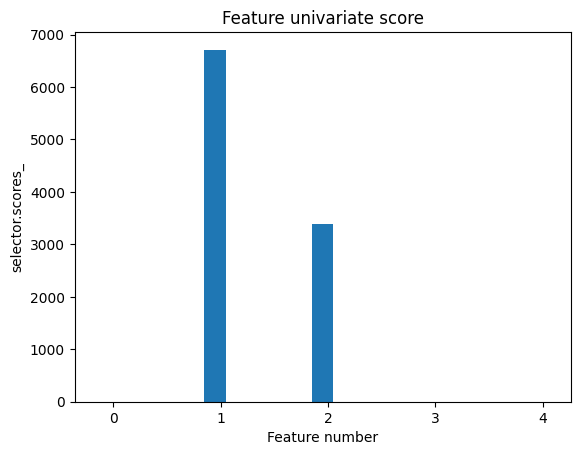

In [ ]:
import matplotlib.pyplot as plt


X_indices = np.arange(factors.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, selector.scores_, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"selector.scores_")
plt.show()

**2 вариант**
Recursive feature elimination

Как работает sklearn.feature_selection.RFE?

Выбирает признак с наименьшим coef_ или feature_importances_ и удаляет его. Так повторяется, пока не останется заранее специфицированное число признаков.

Можно ли считать такой подход оправданным? Что такое стандартизация признаков? Как ее можно сделать и зачем?

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(factors, response)
selector.support_

array([ True,  True, False,  True, False])

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

selector = SelectFromModel(estimator=LinearRegression(), max_features = 5).fit(factors, response)

selector.get_support()

array([False,  True, False, False, False])

# Часть 3

Методы пошагового отбора типа Forward, Backward, Stepwise основаны на проверке статистических гипотез. При этом используется F-test.

https://online.stat.psu.edu/stat462/node/135/

In [ ]:
df.head()

,x,y,t,z,a,u
id,,,,,,
0,132,188,105,15,28.0,1834
1,88,225,76,22,17.0,2045
2,89,183,119,15,17.0,1653
3,79,259,48,17,15.0,2270
4,117,160,138,13,24.0,1555


In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import f
import math

sigLevel = 0.05

model = LinearRegression()
response  = df.iloc[:,-1]
sampleSize = len(response)
factorsNumber = len(df.columns) - 1
factorsToUse = [i for i in range(factorsNumber)]#[0, 1, 2, 3, 4]
factorsInModel = []
factorsToTest = []

restrictedSSE = np.sum(np.square(response - response.mean()))
# x y t z a
flag = True
while flag:
  fullSSE = [math.inf] * factorsNumber
  for i in factorsToUse: # [t, z, a]
    factorsToTest = factorsInModel[:] #[y, x]
    factorsToTest.append(i) # factorsToTest = [y, x, z]
    model.fit(df.iloc[:, factorsToTest], response) #u = Const + b_1 y + b_2 x + b_3 z
    pred = model.predict(df.iloc[:, factorsToTest])
    fullSSE[i] = np.sum(np.square(pred - response)) #

  factorCandidate = np.argmin(fullSSE) # 0 ->
  print('factorCandidate', factorCandidate)
  print('fullSSE', fullSSE)
  dfRmF = 1 #Degrees of Freedom Reduced Minus Full
  dfFull = sampleSize - len(factorsToTest) - 1
  F = ((restrictedSSE - fullSSE[factorCandidate]) / dfRmF) / (fullSSE[factorCandidate] / dfFull)
  print('F', F)
  pvalue = 1 - f.cdf(F, dfRmF, dfFull)

  if pvalue < sigLevel:
    restrictedSSE = fullSSE[factorCandidate]
    factorsInModel.append(factorCandidate)
    factorsToUse.remove(factorCandidate)
  else:
    flag = False

  print('pvalue', pvalue)
  print('factorsInModel', factorsInModel)
  print('\n----------------')

  if(len(factorsToTest) == 0):
    flag = False
    print('All are included')

factorCandidate 1
fullSSE [12512502.673527915, 361837.95500583027, 698600.735631178, 12524222.742020912, 12608932.020094048]
F 6711.752037952221
pvalue 1.1102230246251565e-16
factorsInModel [1]

----------------
factorCandidate 0
fullSSE [105334.29866455839, inf, 361783.9654883981, 361685.62102879316, 361313.9187730983]
F 479.7223785592327
pvalue 1.1102230246251565e-16
factorsInModel [1, 0]

----------------
factorCandidate 3
fullSSE [inf, inf, 105333.88131159669, 102391.99534022938, 105316.3401858832]
F 5.632192728076536
pvalue 0.018600669846179918
factorsInModel [1, 0, 3]

----------------
factorCandidate 4
fullSSE [inf, inf, 102370.5851511081, inf, 102369.67348112428]
F 0.042520039162736604
pvalue 0.8368467908465428
factorsInModel [1, 0, 3]

----------------


Здесь не разделяется обучающая и тестовая выборка.